# 📓 Cross-DEX Statistical Arbitrage Analysis
**Date:** 2025-04-02

## Overview
This notebook explores intra-day statistical arbitrage opportunities for tokens listed on multiple Solana-based decentralized exchanges (DEXes). The objective is to identify and quantify short-term price inefficiencies between DEXes for the same token, and evaluate the statistical validity of arbitrage signals.


## 🧪 Experiment Scope

- **Chains**: Solana  
- **Exchanges**: Raydium, Orca, Meteora  
- **Token universe**: Tokens listed on ≥2 DEXes  
- **Data granularity**: Minute-level time series (1-day partitions per token per exchange)  
- **Source schema**: `SOL_EXCHANGE_TOKEN_FAST`


## 🎯 Objectives

- Align and compare intra-day token price series across DEXes
- Detect price spread violations and convergence patterns
- Apply statistical tests to validate arbitrage opportunities
- Generate per-token/per-day summary metrics


## 🧭 Notebook Plan

### 1. Token Filtering
- Load token mapping from `SOL_EXCHANGE_TOKEN_FAST`
- Filter tokens with multiple DEX listings

### 2. Time-Aligned Price Series
- Load and align price series from each exchange
- Normalize and clean data

### 3. Statistical Diagnostics
- Calculate price spreads and visualize
- Run cointegration and stationarity tests
- Analyze rolling correlation and spread behavior

### 4. Arbitrage Signal Detection
- Detect statistical deviations from spread equilibrium
- Estimate reversion metrics

### 5. Summary Reporting
- Output summary table of opportunities
- Generate token-level charts and diagnostics


In [1]:
import numpy as np
import os
import pandas as pd
import polars as pl
import psycopg2
import pyarrow
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller, coint
import plotly.graph_objects as go

load_dotenv()

True

In [2]:
# 📥 Load Data
# Load token-exchange mapping from the database

filters = {
    "any raydium and any meteora": "(raydium_clmm = TRUE OR raydium_cpmm = TRUE OR raydium_lp = TRUE) AND (meteora_dlmm = TRUE OR meteora_lp = TRUE)",
    "any raydium and any orca": "(raydium_clmm = TRUE OR raydium_cpmm = TRUE OR raydium_lp = TRUE) AND (orca = TRUE)",
}

query = f"""
SELECT contract_address 
FROM SOL_EXCHANGE_TOKEN_FAST 
WHERE {' OR '.join(filters.values())}
"""

conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database="crypto",
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
)
cur = conn.cursor()

cur.execute(query)

rows = cur.fetchall()

tokens = [row[0] for row in rows]


In [11]:
tokens[10:20]

['J3iCHHua352xwxm5nCUf5BSX8kVY5jx7QZPh59P25Cbb',
 'Q5UqzubMK2hqoPtT44TbiQRAwy9s8Zaf2AFxpk8pump',
 '4KRHkYYQggF3h54YjsrtD2MGZyjGRhYMASu5AJHXJn8Y',
 'BXg1LkAHk9rWWbF2tquDsZrVJSWDPK69M7HjfDgkGXSL',
 '9pWPUXoZKWNPWyaegPQeR3Kn8aFz9nrGtm5jeAFzpump',
 'HnCFZNScMWycGAnXUVmj8vHgf9AeWfhTWsVTRzzb4L7s',
 '8FGxHMgcSAuCGfvPW3eQncaRfgbiKPhFptj6c7p1pump',
 'D5BFSZSNUkyGtwHgcDjtkTvPVreAcwBW68BBJdVeNk16',
 'SonicxvLud67EceaEzCLRnMTBqzYUUYNr93DBkBdDES',
 '4Yz5zByTwnVe46AXD6hsrccbq4TKLyih2xRqPyLBDT1P']

In [5]:
print(len(tokens))

22848


In [11]:
path = f"s3://iamjakkie-public/normalized/solana/*/PROGRAM_ID=*/TOKEN=*/*.parquet",
df = pl.scan_parquet(path, 
    storage_options={
        "aws_access_key_id": os.getenv("AWS_ACCESS_KEY"),
        "aws_secret_access_key": os.getenv("AWS_SECRET_KEY"),
    },
)
df = df.filter(pl.col("TOKEN").is_in(tokens))

grouped = df.group_by(
        ["TOKEN", "EXCHANGE"]
    ).agg(
        pl.count().alias("COUNT")
    ).collect(

    ).sort(
        pl.col("COUNT"), descending=True
    ).filter(pl.col("COUNT") > 1000)


/var/folders/8b/j3nhvw4x4wb29hy6w6ggnk140000gn/T/ipykernel_34604/2194030621.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("COUNT")


In [14]:
grouped_per_program = grouped.group_by("TOKEN").agg(
    pl.col("EXCHANGE")
).sort(
    pl.col("EXCHANGE").list.len(), descending=True
)

In [15]:
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000, tbl_cols=-1, tbl_rows=-1):
    print(grouped_per_program)

shape: (32, 2)
┌──────────────────────────────────────────────┬────────────────────────────────────────────────┐
│ TOKEN                                        ┆ EXCHANGE                                       │
│ ---                                          ┆ ---                                            │
│ str                                          ┆ list[str]                                      │
╞══════════════════════════════════════════════╪════════════════════════════════════════════════╡
│ EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v ┆ ["RAYDIUM_CLMM", "RAYDIUM_LP", … "METEORA_LP"] │
│ DezXAZ8z7PnrnRJjz3wXBoRgixCa6xjnB7YaB1pPB263 ┆ ["ORCA", "RAYDIUM_CLMM", "RAYDIUM_LP"]         │
│ 4vMsoUT2BWatFweudnQM1xedRLfJgJ7hswhcpz4xgBTy ┆ ["RAYDIUM_LP"]                                 │
│ ATLASXmbPQxBUYbxPsV97usA3fPQYEqzQBUHgiFCUsXx ┆ ["RAYDIUM_LP"]                                 │
│ HHjoYwUp5aU6pnrvN4s2pwEErwXNZKhxKGYjRJMoBjLw ┆ ["RAYDIUM_LP"]                                 │
│ 4k3

In [28]:
df.collect_schema()

Schema([('BLOCK_DATE', String),
        ('block_time', Int64),
        ('block_slot', UInt64),
        ('SIGNATURE', String),
        ('EXCHANGE', String),
        ('TOKEN', String),
        ('SIDE', String),
        ('TOKEN_AMOUNT', Float64),
        ('QUOTE_ASSET', String),
        ('QUOTE_AMOUNT', Float64),
        ('DERIVED_PRICE', Float64),
        ('USD_PRICE', Float64),
        ('VOLUME', Float64)])

## Align Price Series

In [4]:
test = df.limit(100).collect()

/var/folders/8b/j3nhvw4x4wb29hy6w6ggnk140000gn/T/ipykernel_94292/2542248281.py:1: UserWarning: '(default_)region' not set; polars will try to get it from bucket

Set the region manually to silence this warning.
  test = df.limit(100).collect()


In [ ]:
df.with_columns([
    (pl.col("block_time")*1_000).cast(pl.Datetime).dt.truncate('10s')
])

NameError: name 'test' is not defined

In [16]:
# 🔄 Align Price Series
# For each token, extract and align price data across all DEXes

# Step 1: Create 10s buckets
df = df.with_columns([
    (pl.col("block_time")*1_000).cast(pl.Datetime).alias("datetime"),
]).with_columns([
    pl.col("datetime").dt.truncate("10s").alias("bucket")
])

# Step 2: Aggregating the data (VWAP for each bucket per token and exchange)
agg_df = (
    df.group_by(["TOKEN", "EXCHANGE", "bucket"])
    .agg([
        (pl.col("USD_PRICE") * pl.col("VOLUME")).sum().alias("notional"),
        pl.col("VOLUME").sum().alias("volume")
    ])
    .with_columns([
        (pl.col("notional") / pl.col("volume")).alias("vwap")
    ])
)

token_df = (
    agg_df
    .filter(pl.col("TOKEN") == "DezXAZ8z7PnrnRJjz3wXBoRgixCa6xjnB7YaB1pPB263")
    .select(["bucket", "EXCHANGE", "vwap"])
    .collect()
    .pivot(index="bucket", columns="EXCHANGE", values="vwap")
    .sort("bucket")
    .fill_null(strategy="forward")  # Handling any gaps in data
)



/var/folders/8b/j3nhvw4x4wb29hy6w6ggnk140000gn/T/ipykernel_34604/2013223196.py:28: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(index="bucket", columns="EXCHANGE", values="vwap")


In [19]:
token_df.shape

(9943, 4)

In [35]:
token_df.write_csv("token_df.csv")

In [22]:
pandas_df

BLOCK_DATE     block_time  block_slot  \
0       2023-02-01  1675248241000   175474083   
1       2023-02-01  1675280868000   175537538   
2       2023-02-01  1675214194000   175408701   
3       2023-02-01  1675224137000   175427142   
4       2023-02-01  1675224166000   175427199   
...            ...            ...         ...   
474820  2023-02-07  1675752879000   176475616   
474821  2023-02-07  1675777867000   176528796   
474822  2023-02-07  1675776890000   176526736   
474823  2023-02-07  1675800171000   176574028   
474824  2023-02-07  1675729586000   176426283   

                                                SIGNATURE    EXCHANGE  \
0       2et99ARKUBBiZrEmhk1zQePKXMjPPbPik7JJibcRXDpDvH...  RAYDIUM_LP   
1       2hF8xgH71pGV7CsuWbPPmKVwJir6i7L5rs3sxavq3hYTyw...  RAYDIUM_LP   
2       3HAnLWnf6rNhpvkuYrvGqss8TAUp1wEqTcTGczT7nTBrq9...  RAYDIUM_LP   
3       5KGFRGjSFSXUm3sTEHQN8Pce2VniyFjEh6BWhW7Eni6FJ7...  RAYDIUM_LP   
4       5V4VM87p1Yhy4oGFAY918V53w7BtH6upPbLN39vUFzspYk...  RAYDIUM_LP   
...                                                   ...         ...   
474820  4UMoGNArK569mSkwq1ahwJTaCR1tKMvb6YS3CGuqWT5Hi8...        ORCA   
474821  4Lw9M2HFQNrBAL6yYd838xrjhC2nUyo8JLSgqbedDnq4Vf...        ORCA   
474822  4BiEwFyhDmk2XkqGCnUzWpR3WrY3Bj7AaWYGFDnxLDSSz7...        ORCA   
474823  2y9RHfQq9fXmJkKUHzpe1QRmdQ68tVeeJoJXhjEvSq1nNa...        ORCA   
474824  4BZhPDasanTaFYPsDyto2fLetMSjU9ywaJbfv8NMYoZ5ZF...        ORCA   

                                          PROGRAM_ID  \
0       675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8   
1       675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8   
2       675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8   
3       675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8   
4       675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8   
...                                              ...   
474820   whirLbMiicVdio4qvUfM5KAg6Ct8VwpYzGff3uctyCc   
474821   whirLbMiicVdio4qvUfM5KAg6Ct8VwpYzGff3uctyCc   
474822   whirLbMiicVdio4qvUfM5KAg6Ct8VwpYzGff3uctyCc   
474823   whirLbMiicVdio4qvUfM5KAg6Ct8VwpYzGff3uctyCc   
474824   whirLbMiicVdio4qvUfM5KAg6Ct8VwpYzGff3uctyCc   

                                               TOKEN  SIDE  TOKEN_AMOUNT  \
0       25yPcyqSpSv8T2JWyoKKRiU622Sr7LoMk9S3FmuBFt8S   BUY   1000.000000   
1       25yPcyqSpSv8T2JWyoKKRiU622Sr7LoMk9S3FmuBFt8S   BUY   1000.000000   
2       25yPcyqSpSv8T2JWyoKKRiU622Sr7LoMk9S3FmuBFt8S  SELL   1000.000000   
3       25yPcyqSpSv8T2JWyoKKRiU622Sr7LoMk9S3FmuBFt8S   BUY   1000.000000   
4       25yPcyqSpSv8T2JWyoKKRiU622Sr7LoMk9S3FmuBFt8S   BUY   1000.000000   
...                                              ...   ...           ...   
474820   orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE  SELL      6.678453   
474821   orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE  SELL      1.916640   
474822   orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE   BUY      0.050415   
474823   orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE  SELL      1.706258   
474824   orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE  SELL      0.804031   

                                        QUOTE_ASSET  QUOTE_AMOUNT  \
0       So11111111111111111111111111111111111111112      0.129226   
1       So11111111111111111111111111111111111111112      0.129229   
2       So11111111111111111111111111111111111111112      0.158567   
3       So11111111111111111111111111111111111111112      0.153649   
4       So11111111111111111111111111111111111111112      0.155524   
...                                             ...           ...   
474820  So11111111111111111111111111111111111111112      0.264978   
474821  So11111111111111111111111111111111111111112      0.075578   
474822  So11111111111111111111111111111111111111112      0.002000   
474823  So11111111111111111111111111111111111111112      0.066963   
474824  So11111111111111111111111111111111111111112      0.032672   

        DERIVED_PRICE  USD_PRICE  VOLUME            datetime  \
0            0.000129   0.003020    3.02 2023-02-01 10:44:01   

In [25]:
token_df.head()

shape: (5, 4)
┌─────────────────────┬──────┬────────────┬──────────────┐
│ bucket              ┆ ORCA ┆ RAYDIUM_LP ┆ RAYDIUM_CLMM │
│ ---                 ┆ ---  ┆ ---        ┆ ---          │
│ datetime[μs]        ┆ f64  ┆ f64        ┆ f64          │
╞═════════════════════╪══════╪════════════╪══════════════╡
│ 2023-02-01 00:02:40 ┆ null ┆ 8.7741e-7  ┆ null         │
│ 2023-02-01 00:03:00 ┆ null ┆ 8.7741e-7  ┆ 8.7434e-7    │
│ 2023-02-01 00:03:10 ┆ null ┆ 8.7741e-7  ┆ 8.7369e-7    │
│ 2023-02-01 00:03:30 ┆ null ┆ 8.7784e-7  ┆ 8.7303e-7    │
│ 2023-02-01 00:03:40 ┆ null ┆ 8.6886e-7  ┆ 8.7291e-7    │
└─────────────────────┴──────┴────────────┴──────────────┘

In [26]:
exchanges = ["ORCA", "RAYDIUM_LP", "RAYDIUM_CLMM", "RAYDIUM_CPMM", "METEORA_LP", "METEORA_DLMM"]

In [28]:
pandas_df = token_df.to_pandas()

fig = go.Figure()

# Add each DEX price series
for dex in exchanges:
    if dex in pandas_df.columns:
        fig.add_trace(go.Scatter(
            x=pandas_df["bucket"],
            y=pandas_df[dex],
            mode="lines",
            name=dex
        ))

# Styling
fig.update_layout(
    title="DEX Prices Over Time",
    xaxis_title="Time",
    yaxis_title="Price (USD or Quote Asset)",
    height=600
)

fig.show()

In [29]:
import numpy as np

# Clean NaNs and prevent divide-by-zero
pandas_df["price_ratio"] = np.where(
    (pandas_df["RAYDIUM_LP"].notna()) & (pandas_df["RAYDIUM_CLMM"] > 0),
    pandas_df["RAYDIUM_LP"] / pandas_df["RAYDIUM_CLMM"],
    np.nan
)

# Optional: Clip extreme ratios
pandas_df["price_ratio"] = pandas_df["price_ratio"].clip(lower=0, upper=3)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pandas_df["bucket"],
    y=pandas_df["price_ratio"],
    mode="lines",
    name="Raydium / Meteora"
))

fig.update_layout(
    title="Price Ratio: Raydium vs Meteora",
    xaxis_title="Time",
    yaxis_title="Ratio (RAYDIUM_LP / RAYDIUM_CLMM)",
    height=500
)

fig.show()

In [31]:
# 📊 Statistical Analysis
# Run cointegration, ADF, spread stats, correlation

spread_df = token_df.with_columns([
    (pl.col("RAYDIUM_LP") - pl.col("ORCA")).alias("SPREAD_RAYDIUMLP_ORCA"),
    (pl.col("RAYDIUM_LP") - pl.col("RAYDIUM_CLMM")).alias("SPREAD_RAYDIUMLP_RAYDIUMCLMM"),
    (pl.col("ORCA") - pl.col("RAYDIUM_CLMM")).alias("SPREAD_ORCA_RAYDIUMCLMM"),
])




In [32]:
spread = spread_df["SPREAD_RAYDIUMLP_RAYDIUMCLMM"].to_numpy()
spread = spread[~np.isnan(spread) & ~np.isinf(spread)]
result = adfuller(spread, maxlag=1, regression='c')
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -32.52490094789296
p-value: 0.0


In [7]:
pandas_df["spread"] = pandas_df["RAYDIUM"] - pandas_df["METEORA"]

# Z-score
mean = pandas_df["spread"].mean()
std = pandas_df["spread"].std()
pandas_df["zscore"] = (pandas_df["spread"] - mean) / std

# Define thresholds
entry_threshold = 2.0
exit_threshold = 0.5

# Entry/exit signals
pandas_df["long_entry"] = pandas_df["zscore"] < -entry_threshold
pandas_df["short_entry"] = pandas_df["zscore"] > entry_threshold
pandas_df["exit"] = pandas_df["zscore"].abs() < exit_threshold

In [9]:
fig = go.Figure()

# Z-score line
fig.add_trace(go.Scatter(x=pandas_df["bucket"], y=pandas_df["zscore"],
                         mode="lines", name="Z-Score"))

# Threshold bands
fig.add_trace(go.Scatter(x=pandas_df["bucket"], y=[entry_threshold]*len(pandas_df),
                         mode="lines", name="+2σ", line=dict(dash="dot", color="red")))
fig.add_trace(go.Scatter(x=pandas_df["bucket"], y=[-entry_threshold]*len(pandas_df),
                         mode="lines", name="-2σ", line=dict(dash="dot", color="green")))
fig.add_trace(go.Scatter(x=pandas_df["bucket"], y=[exit_threshold]*len(pandas_df),
                         mode="lines", name="+0.5σ", line=dict(dash="dash", color="gray")))
fig.add_trace(go.Scatter(x=pandas_df["bucket"], y=[-exit_threshold]*len(pandas_df),
                         mode="lines", name="-0.5σ", line=dict(dash="dash", color="gray")))

# Long entries
fig.add_trace(go.Scatter(x=pandas_df.loc[pandas_df["long_entry"], "bucket"],
                         y=pandas_df.loc[pandas_df["long_entry"], "zscore"],
                         mode="markers", name="Long Entry",
                         marker=dict(symbol="triangle-up", color="green", size=8)))

# Short entries
fig.add_trace(go.Scatter(x=pandas_df.loc[pandas_df["short_entry"], "bucket"],
                         y=pandas_df.loc[pandas_df["short_entry"], "zscore"],
                         mode="markers", name="Short Entry",
                         marker=dict(symbol="triangle-down", color="red", size=8)))

# Exit markers
fig.add_trace(go.Scatter(x=pandas_df.loc[pandas_df["exit"], "bucket"],
                         y=pandas_df.loc[pandas_df["exit"], "zscore"],
                         mode="markers", name="Exit",
                         marker=dict(symbol="x", color="black", size=6)))

fig.update_layout(title="Z-Score of Spread with Entry and Exit Signals",
                  yaxis_title="Z-Score",
                  xaxis_title="Time",
                  height=600)

fig.show()

In [25]:
price1 = token_df["RAYDIUM"].to_numpy()
price2 = token_df["METEORA"].to_numpy()

mask = ~(
    np.isnan(price1) | np.isnan(price2) |
    np.isinf(price1) | np.isinf(price2)
)

price1_clean = price1[mask]
price2_clean = price2[mask]

score, pvalue, _ = coint(price1_clean, price2_clean)
print("Cointegration test p-value:", pvalue)

Cointegration test p-value: 0.0


In [49]:
pandas_df["rolling_corr_RAYDIUMLP_RAYDIUMCLMM"] = pandas_df["RAYDIUM_LP"].rolling(30).corr(pandas_df["RAYDIUM_CLMM"])

In [43]:
rolling_corr

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
9938   -0.078574
9939   -0.096013
9940   -0.118700
9941   -0.148500
9942   -0.229490
Length: 9943, dtype: float64

In [39]:
import matplotlib.pyplot as plt

<Axes: >

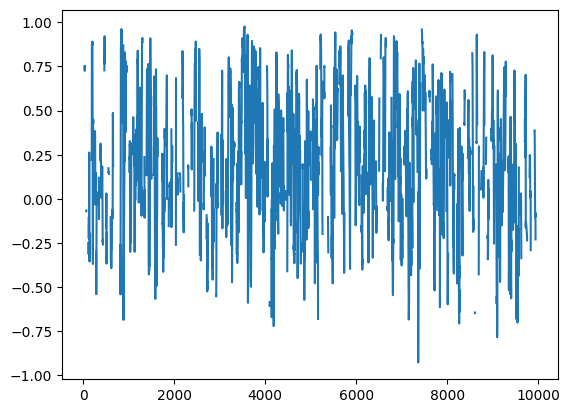

In [40]:
rolling_corr.plot()

In [50]:
pandas_df["corr_smooth_RAYDIUMLP_RAYDIUMCLMM"] = pandas_df["rolling_corr_RAYDIUMLP_RAYDIUMCLMM"].ewm(span=50).mean()

In [52]:
import ruptures as rpt

/Users/jakkie/Dev/dex-statarb-research/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning:

invalid value encountered in reduce

/Users/jakkie/Dev/dex-statarb-research/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning:

invalid value encountered in subtract



(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

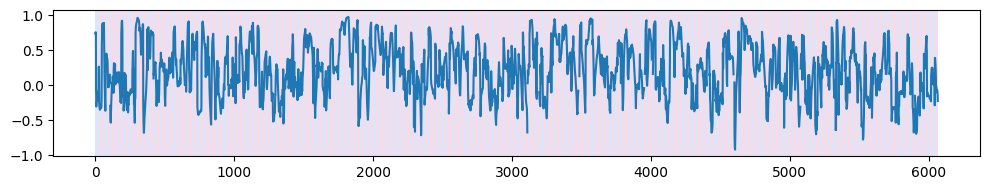

In [53]:

signal = pandas_df["rolling_corr_RAYDIUMLP_RAYDIUMCLMM"].dropna().values
model = "l2"
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=10)

# Plot breakpoints
rpt.display(signal, result)

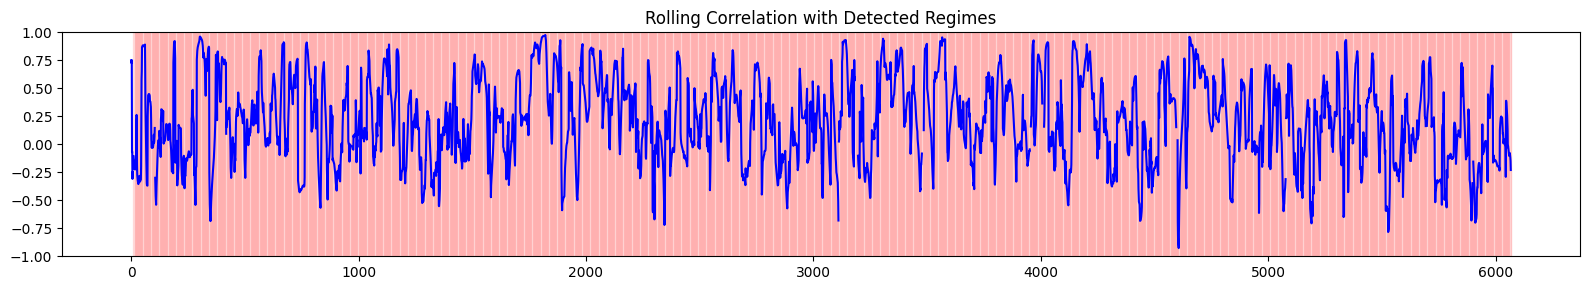

In [54]:

fig, ax = plt.subplots(figsize=(16, 3))

# Plot rolling correlation
ax.plot(signal, label="Rolling Corr", color="blue")

# Highlight regimes
for i in range(len(result)-1):
    ax.axvspan(result[i], result[i+1], color="red", alpha=0.1)

ax.set_ylim([-1, 1])
ax.set_title("Rolling Correlation with Detected Regimes")
plt.tight_layout()
plt.show()

In [ ]:
# 🚨 Signal Detection
# Detect spread breaks and reversions

# TODO: Add threshold logic and opportunity tracking

In [ ]:
# 📈 Reporting
# Generate summary tables and plots

# TODO: Create dashboards and export results